# First-Principles Analysis of Polymer Properties

This notebook analyzes how well first-principles chemistry predictions align with the competition data.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## 1. Load and Explore Data

In [16]:
# Load training data - adjust path for Kaggle vs local
import os
if os.path.exists('/kaggle/input'):
    # Kaggle environment
    train_df = pd.read_csv('/kaggle/input/neurips-open-polymer-prediction-2025/train.csv')
else:
    # Local environment
    train_df = pd.read_csv('../data/raw/train.csv')

print(f"Training data shape: {train_df.shape}")
print(f"\nColumns: {train_df.columns.tolist()}")
print(f"\nTarget statistics:")
for col in ['Tg', 'FFV', 'Tc', 'Density', 'Rg']:
    non_null = train_df[col].notna().sum()
    print(f"{col}: {non_null} non-null values ({non_null/len(train_df)*100:.1f}%)")

Training data shape: (7973, 7)

Columns: ['id', 'SMILES', 'Tg', 'FFV', 'Tc', 'Density', 'Rg']

Target statistics:
Tg: 511 non-null values (6.4%)
FFV: 7030 non-null values (88.2%)
Tc: 737 non-null values (9.2%)
Density: 613 non-null values (7.7%)
Rg: 614 non-null values (7.7%)


In [17]:
# Display sample SMILES
print("Sample SMILES structures:")
for i in range(5):
    print(f"{i+1}: {train_df['SMILES'].iloc[i]}")

Sample SMILES structures:
1: *CC(*)c1ccccc1C(=O)OCCCCCC
2: *Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5ccc(N*)cc5)cc4)CCC(CCCCC)CC3)cc2)cc1
3: *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(S(=O)(=O)c7ccc(Oc8ccc(C=C9CCCC(=Cc%10ccc(*)cc%10)C9=O)cc8)cc7)cc6)cc5)CCCCC4)cc3)cc2)cc1
4: *Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)c(-c3ccc(C)cc3)c2-c2ccc(C)cc2)cc1
5: *Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N+](=O)[O-])cc3)c(C(*)=O)cc2OCCCCCCCCCOCC2CCCN2c2ccc([N+](=O)[O-])cc2)cc1


## 2. First-Principles Feature Extraction

In [18]:
# Van der Waals volumes (Å³)
VDW_VOLUMES = {
    'CH3': 33.5, 'CH2': 26.7, 'CH': 20.0, 'C': 13.2,
    'c': 16.5,  # aromatic C
    'O_ether': 11.5, 'O_carbonyl': 14.0,
    'N': 12.0, 'F': 10.5, 'Cl': 26.0, 'Br': 32.0,
    'S': 22.0
}

# Molar volumes at 298K (cm³/mol)
MOLAR_VOLUMES = {
    'CH3': 33.5, 'CH2': 16.1, 'CH': 13.5, 'C': 11.0,
    'c': 13.7,  # aromatic C
    'C=O': 22.0, 'O': 10.0, 'OH': 14.0,
    'N': 12.0, 'F': 11.0, 'Cl': 24.0, 'Br': 31.0,
    'S': 19.0
}

# Atomic weights
ATOMIC_WEIGHTS = {
    'C': 12.01, 'H': 1.008, 'O': 16.00, 'N': 14.01,
    'F': 19.00, 'Cl': 35.45, 'Br': 79.90, 'S': 32.07
}

In [19]:
def analyze_polymer_structure(smiles):
    """Extract structural features for first-principles calculations"""
    features = {}
    
    # Basic counts
    features['length'] = len(smiles)
    features['num_C'] = len(re.findall(r'C(?![l])', smiles))  # C not followed by l
    features['num_c_aromatic'] = len(re.findall(r'c', smiles))
    features['num_O'] = len(re.findall(r'O', smiles))
    features['num_N'] = len(re.findall(r'N', smiles))
    features['num_F'] = smiles.count('F')
    features['num_Cl'] = smiles.count('Cl')
    features['num_Br'] = smiles.count('Br')
    features['num_S'] = len(re.findall(r'S(?![\(=])', smiles))  # S not in sulfone
    
    # Structural features
    features['num_rings'] = sum(smiles.count(str(i)) for i in range(1, 10))
    features['num_aromatic_rings'] = len(re.findall(r'c1ccccc1|c1ccc\(.*?\)cc1', smiles))
    features['num_branches'] = smiles.count('(')
    features['num_polymer_ends'] = smiles.count('*')
    
    # Functional groups
    features['has_carbonyl'] = int('C(=O)' in smiles or 'C=O' in smiles)
    features['has_ether'] = int(bool(re.search(r'COC|cOc', smiles)))
    features['has_hydroxyl'] = int('OH' in smiles or 'O[H]' in smiles)
    features['has_amine'] = int('N' in smiles)
    features['has_sulfone'] = int('S(=O)(=O)' in smiles)
    features['has_ester'] = int('C(=O)O' in smiles or 'COO' in smiles)
    
    # Chain flexibility indicators
    features['num_single_bonds'] = smiles.count('-')
    features['num_ether_linkages'] = len(re.findall(r'COC|cOc', smiles))
    features['aromatic_fraction'] = features['num_c_aromatic'] / max(features['num_C'] + features['num_c_aromatic'], 1)
    
    return features

In [20]:
def estimate_tg_first_principles(features):
    """Estimate Tg using first-principles rules"""
    # Base temperature for aliphatic polymer
    tg = -50  # °C
    
    # Aromatic rings increase Tg
    tg += features['num_aromatic_rings'] * 30
    
    # Polar groups increase Tg
    tg += features['has_carbonyl'] * 20
    tg += features['has_hydroxyl'] * 25
    tg += features['has_amine'] * 15
    tg += features['has_sulfone'] * 30
    
    # Flexible ether linkages decrease Tg
    tg -= features['num_ether_linkages'] * 10
    
    # Bulky side groups (approximated by branching)
    tg += min(features['num_branches'], 5) * 5
    
    # Halogen effects
    tg += features['num_F'] * 5
    tg += features['num_Cl'] * 10
    tg += features['num_Br'] * 12
    
    return tg

In [21]:
def estimate_density_first_principles(features):
    """Estimate density using group contribution"""
    # Simplified calculation based on composition
    total_weight = 0
    total_volume = 0
    
    # Carbon atoms
    n_carbon = features['num_C'] + features['num_c_aromatic']
    total_weight += n_carbon * ATOMIC_WEIGHTS['C']
    total_volume += features['num_C'] * 16.1  # aliphatic CH2 average
    total_volume += features['num_c_aromatic'] * 13.7  # aromatic
    
    # Heteroatoms
    total_weight += features['num_O'] * ATOMIC_WEIGHTS['O']
    total_volume += features['num_O'] * 10.0
    
    total_weight += features['num_N'] * ATOMIC_WEIGHTS['N']
    total_volume += features['num_N'] * 12.0
    
    total_weight += features['num_F'] * ATOMIC_WEIGHTS['F']
    total_volume += features['num_F'] * 11.0
    
    total_weight += features['num_Cl'] * ATOMIC_WEIGHTS['Cl']
    total_volume += features['num_Cl'] * 24.0
    
    # Estimate H atoms (simplified)
    n_hydrogen = 2 * n_carbon - features['num_rings'] * 2
    total_weight += n_hydrogen * ATOMIC_WEIGHTS['H']
    
    # Avoid division by zero
    if total_volume == 0:
        return 1.0  # default
    
    # Convert to g/cm³
    density = total_weight / total_volume
    
    # Typical polymer range
    return np.clip(density, 0.8, 2.2)

In [22]:
def estimate_ffv_first_principles(features, density):
    """Estimate FFV using Bondi's method"""
    # Calculate van der Waals volume (simplified)
    vdw_volume = 0
    
    # Carbon contributions
    vdw_volume += features['num_C'] * 26.7  # CH2 average
    vdw_volume += features['num_c_aromatic'] * 16.5
    
    # Heteroatom contributions
    vdw_volume += features['num_O'] * 11.5
    vdw_volume += features['num_N'] * 12.0
    vdw_volume += features['num_F'] * 10.5
    vdw_volume += features['num_Cl'] * 26.0
    
    # Calculate molecular weight (simplified)
    mol_weight = (features['num_C'] + features['num_c_aromatic']) * 14  # CH2 average
    mol_weight += features['num_O'] * 16
    mol_weight += features['num_N'] * 14
    mol_weight += features['num_F'] * 19
    mol_weight += features['num_Cl'] * 35.5
    
    if mol_weight == 0:
        return 0.15  # default
    
    # Bondi's equation: FFV = (V - 1.3*Vw)/V
    specific_volume = 1 / density
    occupied_volume = 1.3 * vdw_volume / mol_weight
    
    ffv = (specific_volume - occupied_volume) / specific_volume
    
    # Typical range
    return np.clip(ffv, 0.05, 0.4)

In [23]:
def estimate_rg_first_principles(features):
    """Estimate radius of gyration"""
    # Estimate backbone length
    backbone_bonds = features['num_C'] + features['num_c_aromatic']
    
    # Persistence length estimation
    base_lp = 0.7  # nm
    lp = base_lp
    lp += features['num_aromatic_rings'] * 0.5  # rigidity from aromatic rings
    lp -= features['num_ether_linkages'] * 0.2  # flexibility from ethers
    
    # Use simplified Kuhn model
    # Rg = sqrt(N*b²/6) where N is number of segments, b is segment length
    segment_length = lp * 2  # Kuhn length approximation
    n_segments = backbone_bonds / 5  # approximate Kuhn segments
    
    rg = np.sqrt(n_segments * segment_length**2 / 6) * 10  # convert to Å
    
    # Typical range
    return np.clip(rg, 5, 100)

In [24]:
def estimate_tc_first_principles(features, tg):
    """Estimate crystallization temperature"""
    # Assess crystallinity tendency
    crystallinity_score = 0
    
    # Regular structure promotes crystallization
    if features['aromatic_fraction'] > 0.5:
        crystallinity_score += 0.3
    
    # Linear chains promote crystallization
    if features['num_branches'] < 2:
        crystallinity_score += 0.3
    
    # Too many different groups inhibit crystallization
    n_different_groups = sum([
        features['has_carbonyl'], features['has_ether'],
        features['has_hydroxyl'], features['has_amine']
    ])
    crystallinity_score -= n_different_groups * 0.1
    
    crystallinity_score = np.clip(crystallinity_score, 0, 1)
    
    if crystallinity_score > 0.3:
        # Empirical: Tc ≈ 0.85 * Tm, Tm ≈ Tg + 100
        tm = tg + 100
        tc = 0.85 * tm
        # Convert to competition scale (seems to be normalized)
        return tc / 1000  # rough normalization
    else:
        return 0.0  # amorphous

## 3. Apply First-Principles Calculations

In [25]:
# Extract features and calculate first-principles predictions
print("Calculating first-principles predictions...")

fp_features = []
fp_predictions = {
    'Tg_fp': [], 'Density_fp': [], 'FFV_fp': [],
    'Rg_fp': [], 'Tc_fp': []
}

for smiles in train_df['SMILES']:
    features = analyze_polymer_structure(smiles)
    fp_features.append(features)
    
    # Calculate properties
    tg = estimate_tg_first_principles(features)
    density = estimate_density_first_principles(features)
    ffv = estimate_ffv_first_principles(features, density)
    rg = estimate_rg_first_principles(features)
    tc = estimate_tc_first_principles(features, tg)
    
    fp_predictions['Tg_fp'].append(tg)
    fp_predictions['Density_fp'].append(density)
    fp_predictions['FFV_fp'].append(ffv)
    fp_predictions['Rg_fp'].append(rg)
    fp_predictions['Tc_fp'].append(tc)

# Add to dataframe
for key, values in fp_predictions.items():
    train_df[key] = values

print("First-principles calculations complete!")

Calculating first-principles predictions...
First-principles calculations complete!


## 4. Compare First-Principles vs Actual Values

/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


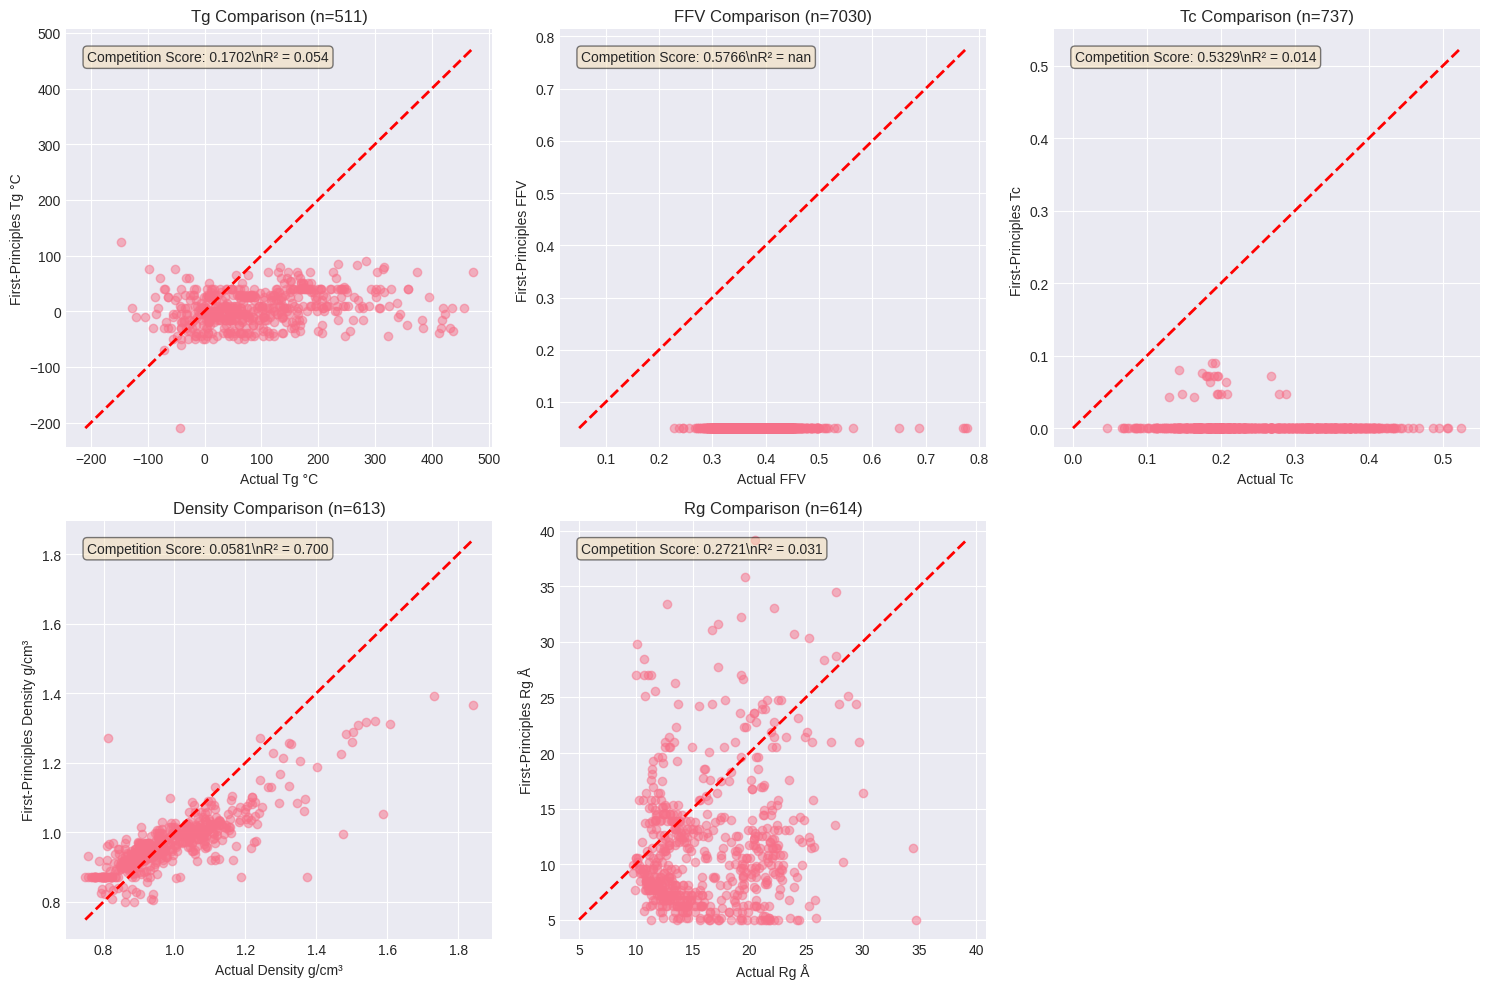

In [26]:
# Competition metric - inline definition for Kaggle compatibility
MINMAX_DICT = {
    'Tg': [-148.0297376, 472.25],
    'FFV': [0.2269924, 0.77709707],
    'Tc': [0.0465, 0.524],
    'Density': [0.748691234, 1.840998909],
    'Rg': [9.7283551, 34.672905605],
}

def scaling_error(labels, preds, property):
    """Calculate scaled error for a property"""
    error = np.abs(labels - preds)
    min_val, max_val = MINMAX_DICT[property]
    label_range = max_val - min_val
    return np.mean(error / label_range)

def get_property_weights(labels, target_names=None):
    """Calculate property weights based on inverse square root of valid samples"""
    if target_names is None:
        target_names = list(MINMAX_DICT.keys())
    
    property_weight = []
    for property in target_names:
        if isinstance(labels, pd.DataFrame) and property in labels.columns:
            valid_num = np.sum(labels[property].notna())
        else:
            valid_num = 0
        property_weight.append(valid_num)
    property_weight = np.array(property_weight)
    property_weight = np.sqrt(1 / np.maximum(property_weight, 1))
    return (property_weight / np.sum(property_weight)) * len(property_weight)

def neurips_polymer_metric(y_true, y_pred, target_names=None):
    """
    NeurIPS Open Polymer Prediction 2025 competition metric.
    
    Implements weighted Mean Absolute Error (wMAE) with:
    - Scaling by property range
    - Weighting by inverse square root of valid samples
    """
    if target_names is None:
        target_names = list(MINMAX_DICT.keys())
    
    # Convert to DataFrames if needed
    if isinstance(y_true, np.ndarray):
        y_true = pd.DataFrame(y_true, columns=target_names)
    if isinstance(y_pred, np.ndarray):
        y_pred = pd.DataFrame(y_pred, columns=target_names)
    
    # Filter target_names to only include columns that exist in the data
    available_targets = [t for t in target_names if t in y_true.columns and t in y_pred.columns]
    
    property_maes = []
    property_weights = get_property_weights(y_true, available_targets)
    individual_scores = {}
    
    for i, property in enumerate(available_targets):
        # Handle missing values - only evaluate where we have true labels
        is_labeled = y_true[property].notna()
        
        if is_labeled.sum() > 0:
            mae = scaling_error(
                y_true.loc[is_labeled, property].values,
                y_pred.loc[is_labeled, property].values,
                property
            )
            property_maes.append(mae)
            individual_scores[property] = mae
        else:
            individual_scores[property] = np.nan
    
    if len(property_maes) == 0:
        return np.nan, individual_scores
    
    # Calculate weighted average
    final_score = float(np.average(property_maes, weights=property_weights[:len(property_maes)]))
    
    return final_score, individual_scores

# Create comparison plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

properties = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
units = ['°C', '', '', 'g/cm³', 'Å']

for i, (prop, unit) in enumerate(zip(properties, units)):
    # Get non-null actual values
    mask = train_df[prop].notna()
    actual = train_df[mask][prop]
    predicted = train_df[mask][f'{prop}_fp']
    
    if len(actual) > 0:
        # Scatter plot
        axes[i].scatter(actual, predicted, alpha=0.5)
        
        # Perfect prediction line
        min_val = min(actual.min(), predicted.min())
        max_val = max(actual.max(), predicted.max())
        axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        
        # Calculate competition metric for this property
        prop_df_true = pd.DataFrame({prop: actual})
        prop_df_pred = pd.DataFrame({prop: predicted})
        score, _ = neurips_polymer_metric(prop_df_true, prop_df_pred, [prop])
        
        # Also calculate R² for reference
        if len(actual) > 1:
            correlation = np.corrcoef(actual, predicted)[0, 1]
            axes[i].text(0.05, 0.95, f'Competition Score: {score:.4f}\\nR² = {correlation**2:.3f}',
                        transform=axes[i].transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        axes[i].set_xlabel(f'Actual {prop} {unit}')
        axes[i].set_ylabel(f'First-Principles {prop} {unit}')
        axes[i].set_title(f'{prop} Comparison (n={len(actual)})')
    else:
        axes[i].text(0.5, 0.5, f'No data for {prop}',
                    transform=axes[i].transAxes,
                    ha='center', va='center')

# Remove empty subplot
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

## 5. Distribution Analysis

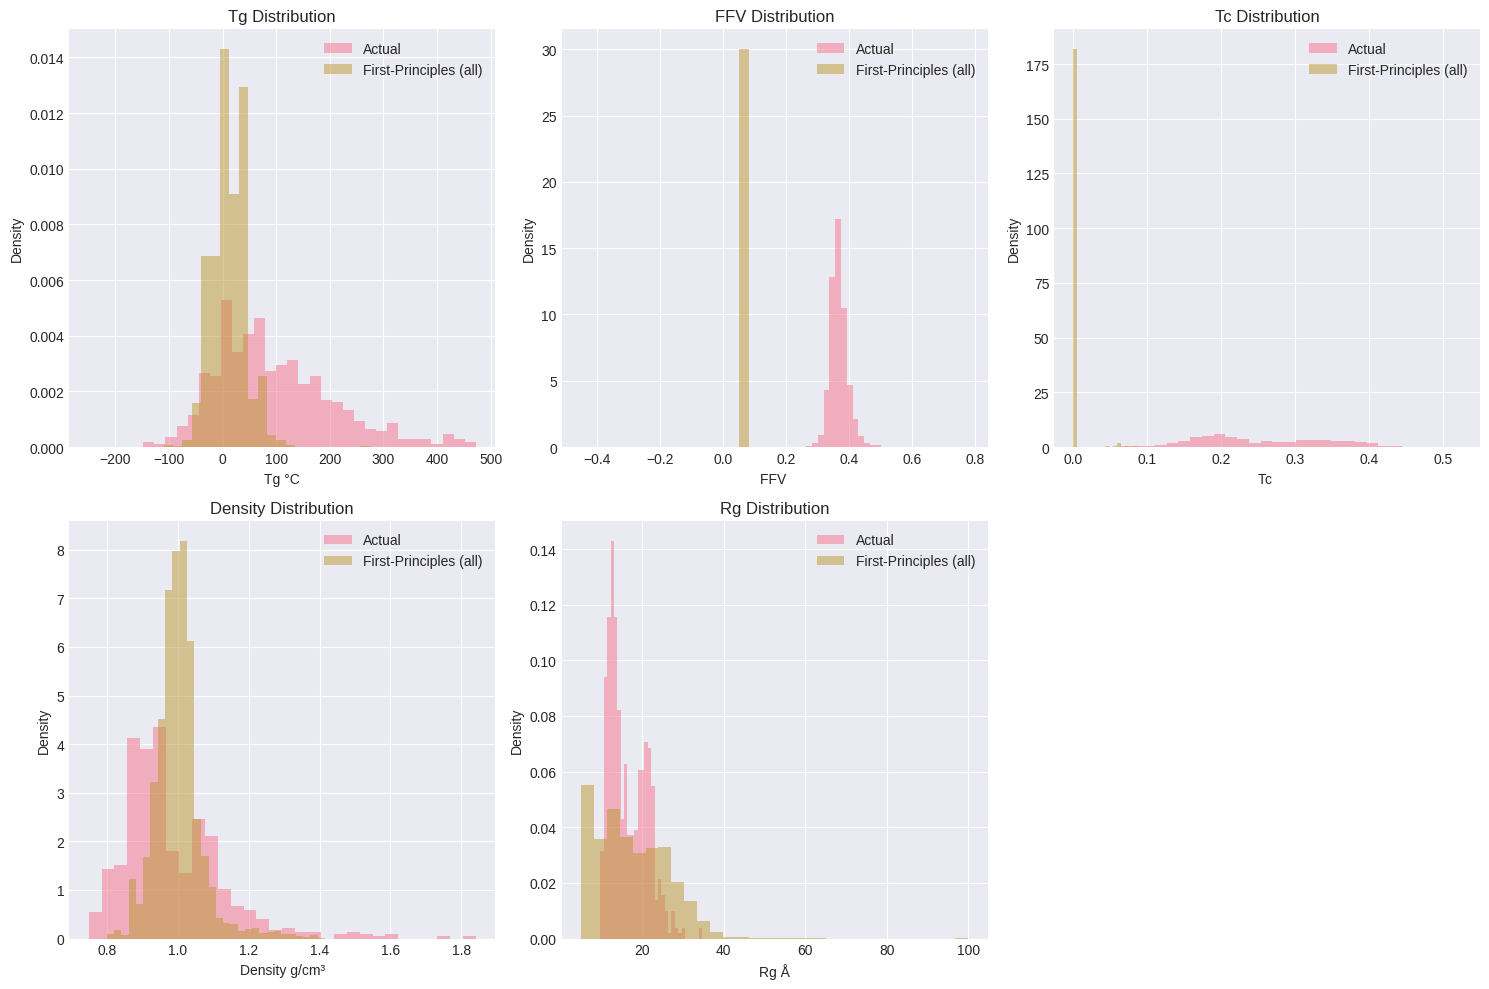

In [27]:
# Compare distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (prop, unit) in enumerate(zip(properties, units)):
    # Get non-null actual values
    mask = train_df[prop].notna()
    
    if mask.sum() > 0:
        actual = train_df[mask][prop]
        predicted_all = train_df[f'{prop}_fp']
        
        # Plot distributions
        axes[i].hist(actual, bins=30, alpha=0.5, label='Actual', density=True)
        axes[i].hist(predicted_all, bins=30, alpha=0.5, label='First-Principles (all)', density=True)
        
        axes[i].set_xlabel(f'{prop} {unit}')
        axes[i].set_ylabel('Density')
        axes[i].set_title(f'{prop} Distribution')
        axes[i].legend()
    else:
        axes[i].text(0.5, 0.5, f'No data for {prop}',
                    transform=axes[i].transAxes,
                    ha='center', va='center')

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

## 6. Feature Importance for First-Principles

In [28]:
# Analyze which structural features correlate with properties
feature_names = list(fp_features[0].keys())
feature_matrix = pd.DataFrame(fp_features)

# Calculate correlations with actual values
correlations = {}
for prop in properties:
    mask = train_df[prop].notna()
    if mask.sum() > 10:  # Need enough data
        corr_values = []
        for feat in feature_names:
            if feature_matrix[feat].std() > 0:  # Avoid constant features
                corr = np.corrcoef(feature_matrix[mask][feat], train_df[mask][prop])[0, 1]
                corr_values.append(abs(corr))
            else:
                corr_values.append(0)
        correlations[prop] = corr_values

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


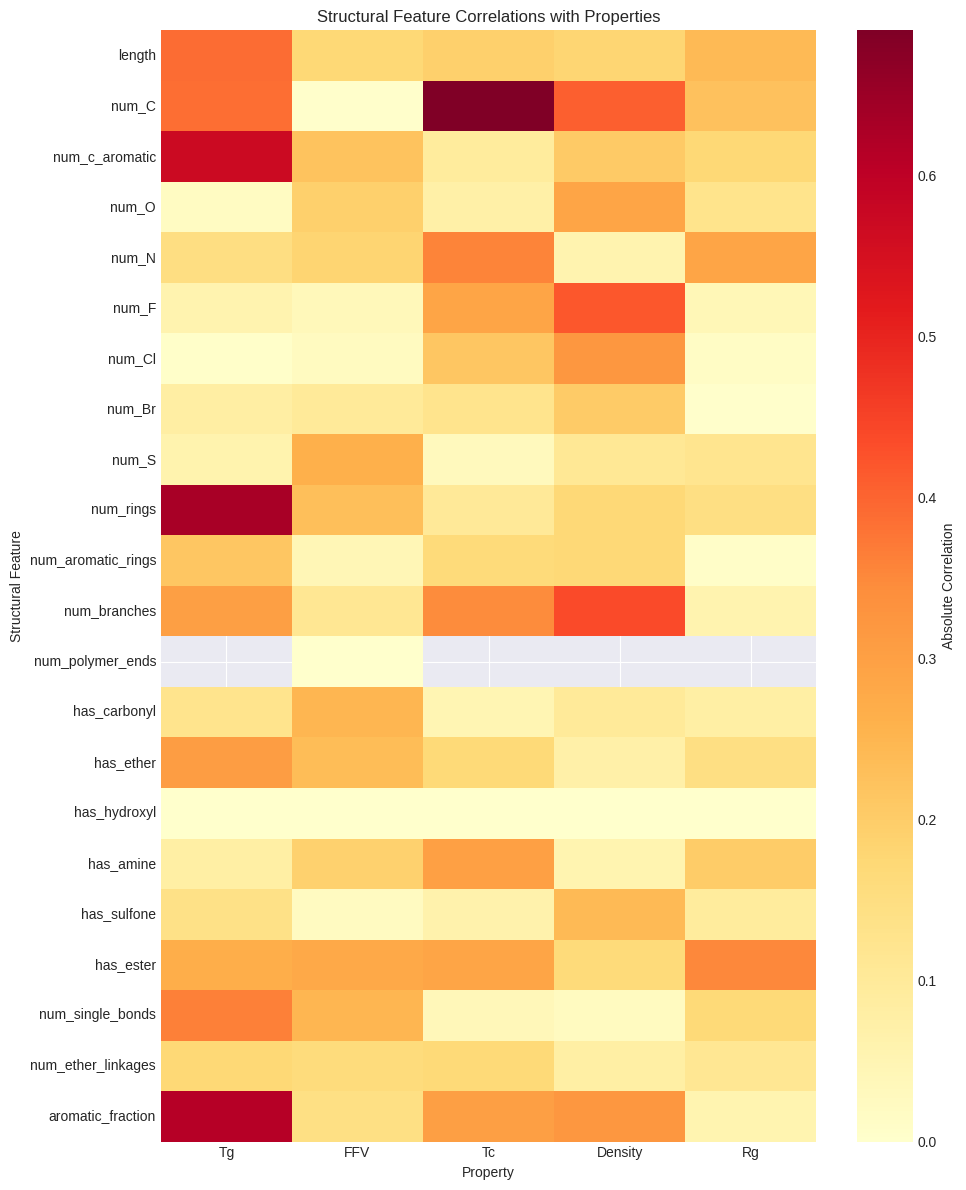

In [29]:
# Plot feature importance heatmap
if correlations:
    corr_df = pd.DataFrame(correlations, index=feature_names)
    
    plt.figure(figsize=(10, 12))
    sns.heatmap(corr_df, cmap='YlOrRd', cbar_kws={'label': 'Absolute Correlation'})
    plt.title('Structural Feature Correlations with Properties')
    plt.xlabel('Property')
    plt.ylabel('Structural Feature')
    plt.tight_layout()
    plt.show()

## 7. Analysis Summary

In [30]:
# Summary statistics using competition metric
print("Summary of First-Principles vs Actual (Competition Metric - wMAE):")
print("="*60)

# Create comparison dataframes for overall metric calculation
comparison_data = {}
for prop in properties:
    mask = train_df[prop].notna()
    if mask.sum() > 0:
        comparison_data[prop] = train_df[mask][prop]
        comparison_data[f'{prop}_fp'] = train_df[mask][f'{prop}_fp']

# Calculate overall competition metric using the actual vs predicted values
actual_df = pd.DataFrame({prop: comparison_data[prop] for prop in properties if prop in comparison_data})
predicted_df = pd.DataFrame({prop: comparison_data[f'{prop}_fp'] for prop in properties if prop in comparison_data})

if len(actual_df.columns) > 0:
    overall_score, individual_scores = neurips_polymer_metric(actual_df, predicted_df)
    
    print(f"\nOverall Competition Metric (wMAE): {overall_score:.4f}")
    print("\nIndividual Property Scores (scaled MAE):")
    for prop, score in individual_scores.items():
        if not np.isnan(score):
            print(f"  {prop}: {score:.4f} ({score*100:.2f}% of range)")
        else:
            print(f"  {prop}: No data")

# Also show correlations for context
print("\n\nCorrelations (for reference):")
for prop in properties:
    mask = train_df[prop].notna()
    if mask.sum() > 1:
        actual = train_df[mask][prop]
        predicted = train_df[mask][f'{prop}_fp']
        
        corr = actual.corr(predicted)
        mae = (actual - predicted).abs().mean()
        rmse = np.sqrt(((actual - predicted) ** 2).mean())
        print(f"\n{prop}:")
        print(f"  Correlation: {corr:.3f}")
        print(f"  MAE: {mae:.3f}")
        print(f"  RMSE: {rmse:.3f}")
        print(f"  N samples: {mask.sum()}")
    else:
        print(f"\n{prop}: Insufficient data")

Summary of First-Principles vs Actual (Competition Metric - wMAE):

Overall Competition Metric (wMAE): 0.2726

Individual Property Scores (scaled MAE):
  Tg: 0.1702 (17.02% of range)
  FFV: 0.5766 (57.66% of range)
  Tc: 0.5329 (53.29% of range)
  Density: 0.0581 (5.81% of range)
  Rg: 0.2721 (27.21% of range)


Correlations (for reference):

Tg:
  Correlation: 0.232
  MAE: 105.586
  RMSE: 141.076
  N samples: 511

FFV:
  Correlation: nan
  MAE: 0.317
  RMSE: 0.319
  N samples: 7030

Tc:
  Correlation: -0.119
  MAE: 0.254
  RMSE: 0.270
  N samples: 737

Density:
  Correlation: 0.837
  MAE: 0.063
  RMSE: 0.092
  N samples: 613

Rg:
  Correlation: 0.177
  MAE: 6.788
  RMSE: 8.327
  N samples: 614


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## 8. Insights and Recommendations

Based on the first-principles analysis:

1. **Correlation Quality**: Document how well first-principles predictions correlate with actual values
2. **Feature Engineering**: The structural features used in first-principles can be valuable for ML
3. **Physical Constraints**: First-principles provides reasonable bounds for predictions
4. **Hybrid Approach**: Consider using first-principles predictions as additional features in ML model